In [1]:
using NearestNeighbors
using Colors
using CairoMakie
using AbstractTrees
using StableRNGs

#### This notebook generates a KD tree and shows visualizations of its hierarchical space partitioning.

In [2]:
rng = StableRNG(42)
tree = KDTree(randn(rng, 2, 500), Euclidean(); leafsize = 50)

KDTree{StaticArraysCore.SVector{2, Float64}, Euclidean, Float64, StaticArraysCore.SVector{2, Float64}}
  Number of points: 500
  Dimensions: 2
  Metric: Euclidean(0.0)
  Reordered: true

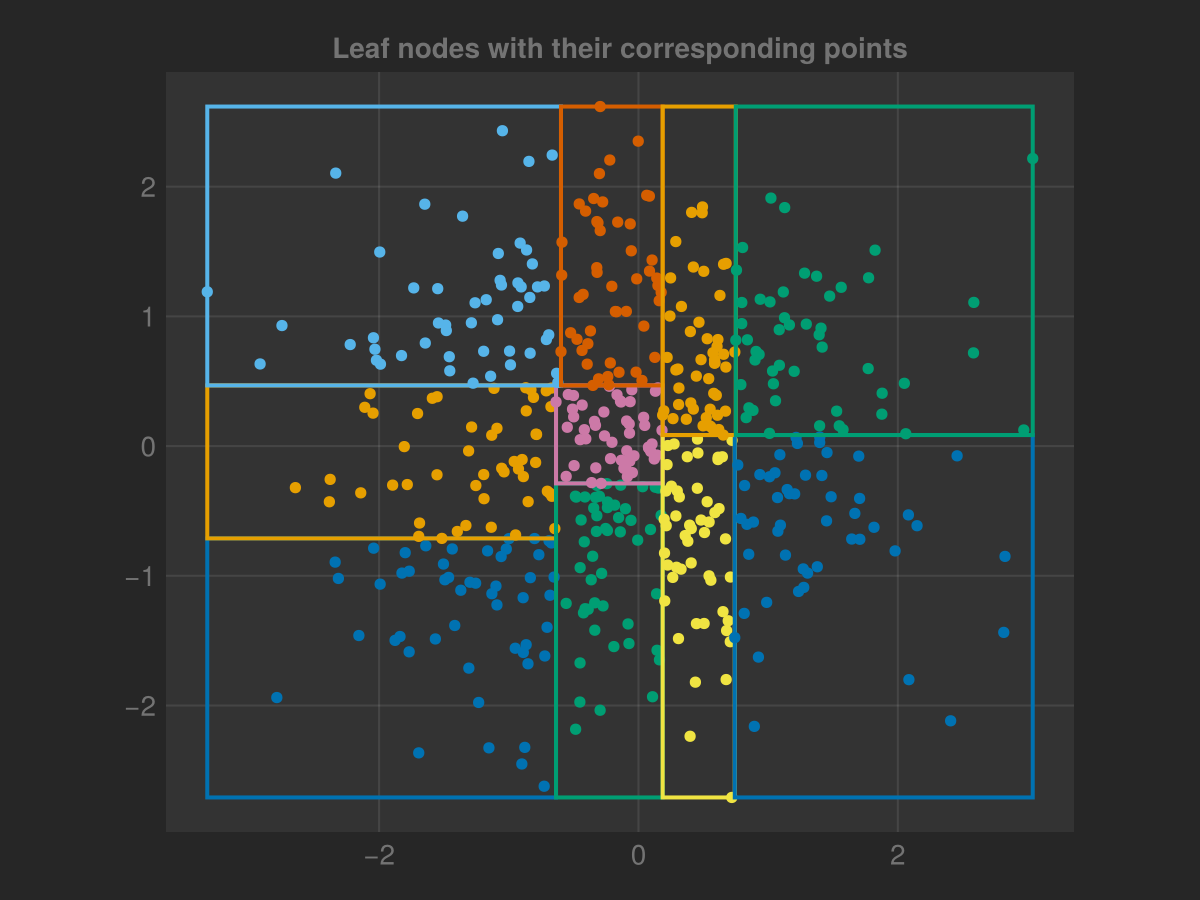

In [3]:
import NearestNeighbors.HyperRectangle
import NearestNeighbors: treeroot, leafpoints, treeregion

set_theme!(theme_dark())

# Adds a rectangle to an axis
function add_rectangle(ax, hr::HyperRectangle, color)
    x_min, x_max = hr.mins[1], hr.maxes[1]
    y_min, y_max = hr.mins[2], hr.maxes[2]
    lines!(ax, [x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min]; color, linewidth=2)
end

# Iterate over the leaf nodes with the public traversal API
root = treeroot(tree)
leaf_nodes = collect(Leaves(root))
cols = Makie.wong_colors()

fig = CairoMakie.Figure(backgroundcolor=:gray15)
ax = Axis(fig[1, 1], aspect = DataAspect(), title = "Leaf nodes with their corresponding points",
          backgroundcolor=:gray20)

for (i, node) in enumerate(leaf_nodes)
    pts = leafpoints(node)
    col = cols[mod1(i, length(cols))]
    scatter!(ax, getindex.(pts, 1), getindex.(pts, 2); markersize=8, color=col)
    add_rectangle(ax, treeregion(node), col)
end

fig

#### Progressive tree splitting by depth

This visualization shows how the KD tree iteratively partitions the space at each depth level.

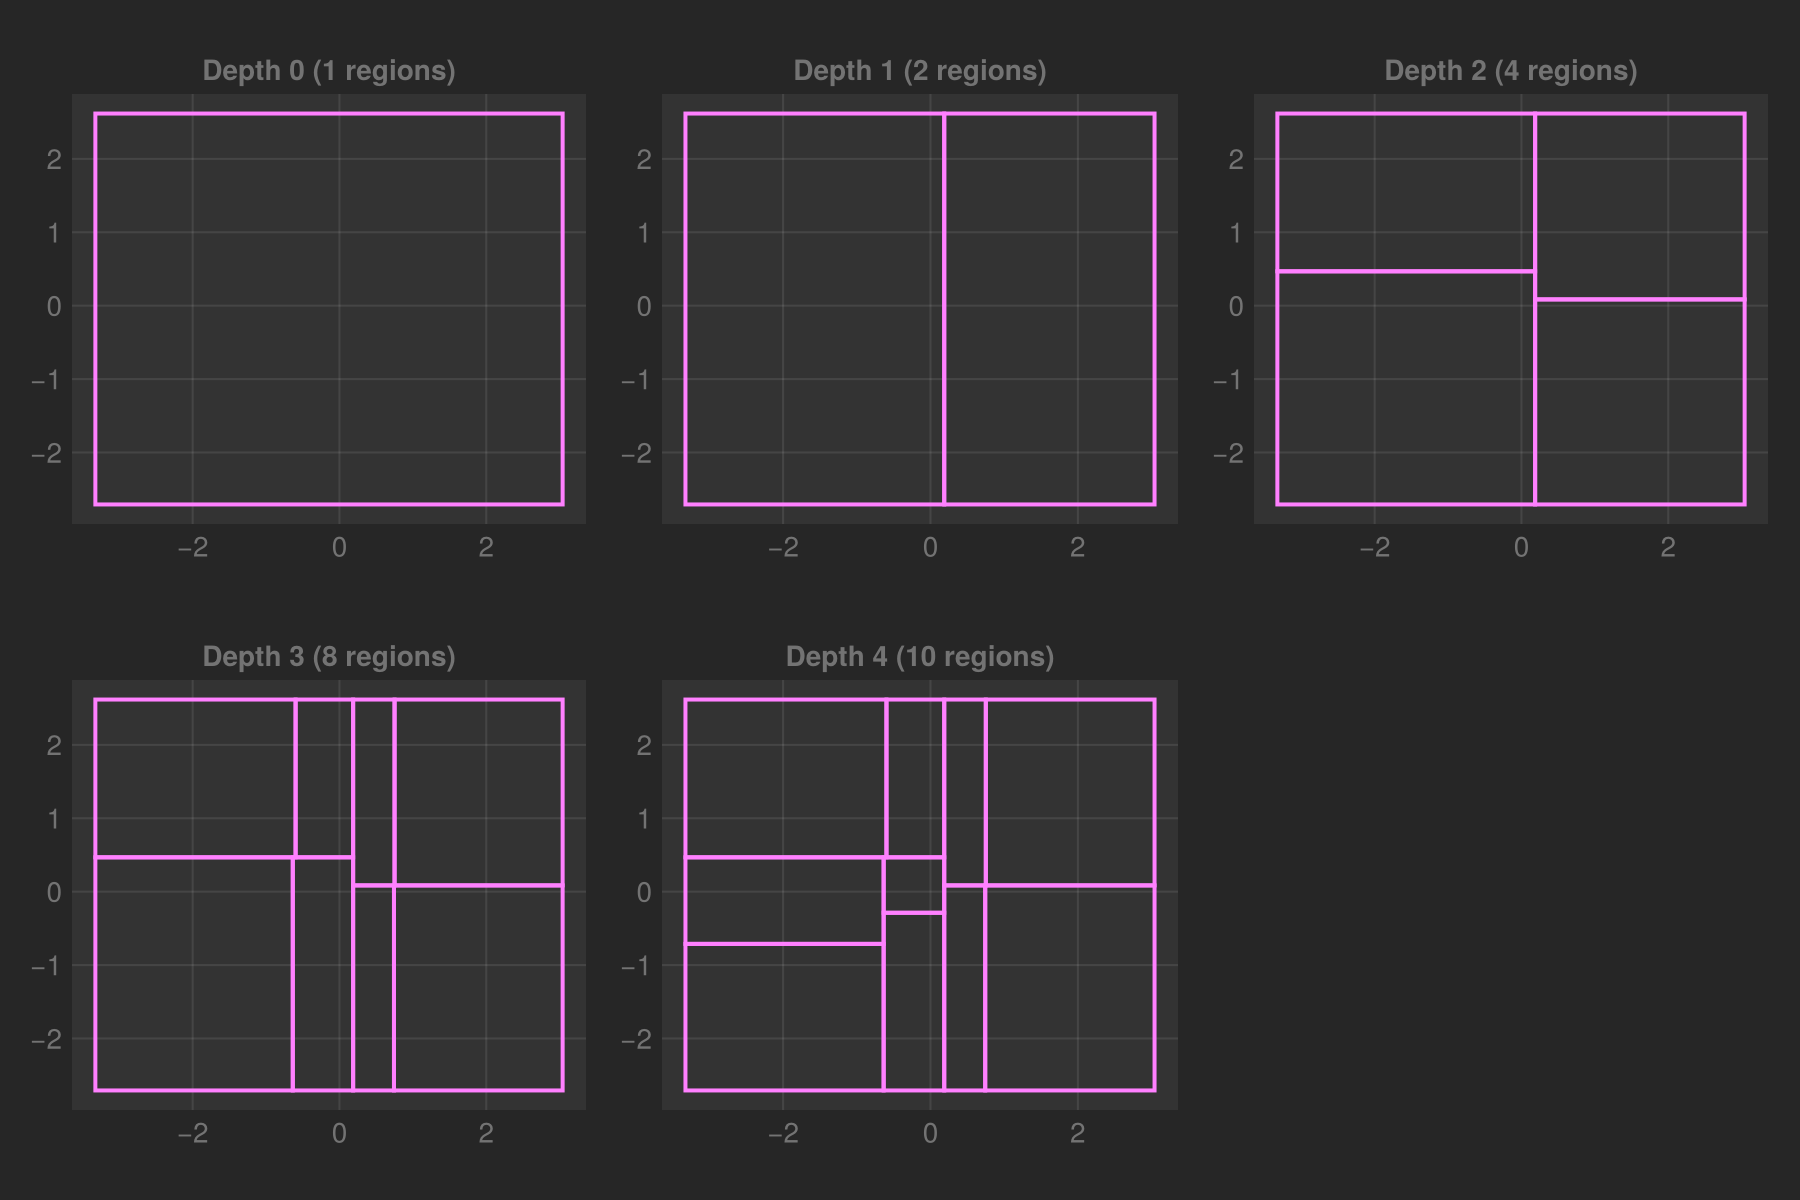

In [4]:
function node_depth(node)
    depth = 0
    current = node
    while !isnothing(AbstractTrees.parent(current))
        current = AbstractTrees.parent(current)
        depth += 1
    end
    return depth
end

# Collect all nodes with their depths
root = treeroot(tree)
all_nodes = collect(PreOrderDFS(root))
node_depths = [node_depth(node) for node in all_nodes]
max_depth = maximum(node_depths)

# For each depth level, get all "active" regions
# (nodes at that depth, or leaves from shallower depths)
function get_active_regions_at_depth(max_depth_to_show)
    active = []
    for (node, depth) in zip(all_nodes, node_depths)
        is_leaf = isempty(children(node))
        if depth == max_depth_to_show || (is_leaf && depth < max_depth_to_show)
            push!(active, node)
        end
    end
    return active
end

# Create figure with 2x3 grid of subplots
n_depths = min(max_depth + 1, 6)  # Show up to 6 depth levels
fig = Figure(backgroundcolor=:gray15, size=(900, 600), title="Foo")

for depth in 0:(n_depths-1)
    active_regions = get_active_regions_at_depth(depth)
    row = div(depth, 3) + 1
    col = mod(depth, 3) + 1
    ax = Axis(fig[row, col], aspect=DataAspect(), 
              title="Depth $depth ($(length(active_regions)) regions)",
              backgroundcolor=:gray20)
    
    # Draw all active regions at this depth
    for (i, node) in enumerate(active_regions)
        add_rectangle(ax, treeregion(node), RGB(1.0, 0.5, 1.0))
    end
end

fig